This notebook is to show comparison between word-level tokenizer (eg. newmm) and subword-level tokenizer (eg. SentencePiece and subword-nmt) in terms of token frequency



For example, compare the token frequency of the following terms:



__Text Input = "ประธานาธิบดี และนายกรัฐมนตรี เดินทางไปเยือนสหรัฐอเมริกา"__

|   Token       |  subword-nmt_vocab-1k  |  sentencepiece_vocab-1k |  newmm    |
| ------------- |:----------------------:|:-----------------------:|:---------:|
| "ประธานาธิบดี"  |        1               |           1             |    1      |
| "นายกรัฐมนตรี"  |        1               |           1             |    1      |




In [126]:
import time
import os
import pythainlp
import io

from matplotlib import pyplot as plt

import seaborn as sns
from collections import Counter
from functools import partial
from datetime import timedelta
from tqdm import tqdm, tqdm_notebook

print(pythainlp.__version__)
assert pythainlp.__version__ == '2.0.5'

2.0.5


In [2]:
# Load opensubtitle_v2018 TH dataset
PATHS = {
    'opensubtitle_v2018': {
        'th': '../data/opensubtitle_v2018/OpenSubtitles.en-th.th',
        'en': '../data/opensubtitle_v2018/OpenSubtitles.en-th.en'
    }
}

def load_dataset(path):
    with open(path, 'r') as f: 
        return f.read().split('\n')


## 1.1 Initialize BPEmb with different vocab size (i.e. SentencePiece BPE)

Reference: https://nlp.h-its.org/bpemb/th/

Available Vocabuary size for BPEmb:

- 1,000
- 3,000
- 5,000
- 10,000
- 25,000
- 50,000
- 100,000
- 200,000

In [7]:
from bpemb import BPEmb


bpemb_vocab_sizes = [1000, 3000, 5000, 10000, 25000, 50000, 100000, 200000]

In [10]:
bpemb_th = {}

for vocab_size in bpemb_vocab_sizes:

    bpemb_th['{}'.format(vocab_size)] = BPEmb(lang="th", vs=vocab_size)

print('bpemb_th', bpemb_th)

bpemb_th {'1000': BPEmb(lang=th, vs=1000, dim=100), '3000': BPEmb(lang=th, vs=3000, dim=100), '5000': BPEmb(lang=th, vs=5000, dim=100), '10000': BPEmb(lang=th, vs=10000, dim=100), '25000': BPEmb(lang=th, vs=25000, dim=100), '50000': BPEmb(lang=th, vs=50000, dim=100), '100000': BPEmb(lang=th, vs=100000, dim=100), '200000': BPEmb(lang=th, vs=200000, dim=100)}


## 1.2 Initialize subword-nmt with different vocab size (learned from opensubtitle_v2018.th)



In [49]:
from subword_nmt import apply_bpe as subword_tokenizer

subwordnmt_bpe = {}
subword_nmt_vocab_sizes = [1000, 5000, 10000, 25000, 100000, 250000]


for vocab_size in subword_nmt_vocab_sizes:
    subwordnmt_bpe['{}'.format(vocab_size)] = subword_tokenizer.BPE(
                        open('../data/opensubtitle_v2018/codes.th.symbol-{}'.format(vocab_size), 'r+'),
                        separator="_")


print('subwordnmt_bpe', subwordnmt_bpe)

subwordnmt_bpe {'1000': <subword_nmt.apply_bpe.BPE object at 0x1561f45c0>, '5000': <subword_nmt.apply_bpe.BPE object at 0x11c244390>, '10000': <subword_nmt.apply_bpe.BPE object at 0x121feeb38>, '25000': <subword_nmt.apply_bpe.BPE object at 0x1175f1d30>, '100000': <subword_nmt.apply_bpe.BPE object at 0x117d882e8>, '250000': <subword_nmt.apply_bpe.BPE object at 0x127dbee48>}


## 2. Count token frequency on opensubtitle_th when tokenize with


Note that `opensubtitle_v2018.th` contains __3,281,534__ sentences,


#### Tokenizers:

1) Dictionary-based tokenizer (__newmm__)

2) __SentencePiece__ 

3) __subword-nmt__ (Pre-tokenize with __newmm__)



In [70]:
# 1. Load dataset

opensubtitle_th = load_dataset(PATHS['opensubtitle_v2018']['th'])
opensubtitle_en = load_dataset(PATHS['opensubtitle_v2018']['en'])



  1%|          | 36059/3281534 [00:20<06:38, 8140.84it/s]

In [72]:
print(len(opensubtitle_en), len(opensubtitle_th))

3281534 3281534


In [81]:
# 2. Count word frequency

text = opensubtitle_th[0]
text

_newmm_tokenizer = partial(pythainlp.tokenize.word_tokenize, engine="newmm", keep_whitespace=False)

tokenizer_names = ['newmm']
tokenizer_names.extend(['sentencepiece-{}'.format(vocab_size) for vocab_size in bpemb_vocab_sizes])
tokenizer_names.extend(['subwordnmt-{}'.format(vocab_size) for vocab_size in subword_nmt_vocab_sizes])
tokenizer_names

['newmm',
 'sentencepiece-1000',
 'sentencepiece-3000',
 'sentencepiece-5000',
 'sentencepiece-10000',
 'sentencepiece-25000',
 'sentencepiece-50000',
 'sentencepiece-100000',
 'sentencepiece-200000',
 'subwordnmt-1000',
 'subwordnmt-5000',
 'subwordnmt-10000',
 'subwordnmt-25000',
 'subwordnmt-100000',
 'subwordnmt-250000']

In [78]:
def count_word_freq(dataset, names):
    counters = {}
    for name in names:
        counters[name] = Counter()
        for index, text in tqdm_notebook(enumerate(dataset), total=len(dataset)):
            if name == 'newmm':
                tokens = _newmm_tokenizer(text)
            else:
                tokenizer_name, vocab_size = name.split('-')
                if tokenizer_name == 'sentencepiece':
                    _tokenizer = partial(bpemb_th['{}'.format(vocab_size)].encode)
                if tokenizer_name == 'subwordnmt':
                    _bpe_tokenizer = partial(subwordnmt_bpe['{}'.format(vocab_size)].segment_tokens)
                    _tokenizer = lambda text: _bpe_tokenizer(_newmm_tokenizer(text))

                tokens = _tokenizer(text)
    #             print(tokens)
            for token in tokens:
                counters[name][token] += 1

    #     print('Counter [{}] :{}'.format(name, counters[name]))


        print('Counter [{}] :{}'.format(name, counters[name].most_common(100)))
        print('')
    return counters

#### Thai word frequency 

In [84]:
thai_counters = count_word_freq(opensubtitle_th[:], tokenizer_names)


Counter [newmm] :[('ฉัน', 588014), ('คุณ', 436424), ('ที่', 390587), ('จะ', 374105), ('ผม', 303063), ('ไป', 297693), ('มัน', 297644), ('?', 287450), ('ว่า', 284314), ('เธอ', 265151), ('ของ', 263629), ('-', 254100), ('ไม่', 248253), ('แล้ว', 243998), ('เรา', 237227), ('เขา', 231293), ('เป็น', 229940), ('ได้', 221616), ('อะไร', 207998), ('นะ', 205681), ('ก็', 189412), ('มา', 187439), ('ให้', 186797), ('อยู่', 163714), ('มี', 160138), ('ใน', 158479), ('และ', 156945), ('กับ', 153534), ('ทำ', 134957), ('นี่', 133317), ('เลย', 130292), ('นาย', 128059), ('ต้อง', 127349), ('...', 126298), ('คน', 121177), ('!', 120588), ('แต่', 119256), ('นี้', 109382), ('รู้', 99284), ('.', 99042), ('ไม่ได้', 93151), ('ใช่', 89387), ('พวก', 82572), (',', 81242), ('ๆ', 80789), ('ถ้า', 79372), ('คิด', 78252), ('เหรอ', 77870), ('คือ', 77818), ('กัน', 77230), ('นั่น', 74460), ('ด้วย', 73533), ('นั้น', 72319), ('เรื่อง', 72013), ('อยาก', 69873), ('บอก', 68029), ('ครับ', 67873), ('การ', 66366), ('แค่', 65799), ('ดี


Counter [sentencepiece-1000] :[('▁', 2230952), ('อ', 1165113), ('ค', 1075042), ('เ', 1045404), ('น', 1020501), ('ม', 1001113), ('ัน', 999533), ('ะ', 906966), ('ร', 855755), ('ย', 809641), ('▁เ', 769652), ('ุ', 691631), ('.', 657716), ('ต', 641951), ('ฉ', 622625), ('ก', 621067), ('ว', 615935), ('ไ', 613239), ('ไม่', 603681), ('่', 592908), ('ง', 551350), ('ล', 550734), ('ส', 548363), ('บ', 537951), ('ที่', 529513), ('ณ', 526913), ('ด', 521983), ('ธ', 518941), ('จะ', 505094), ('า', 486534), ('ข', 467581), ('พ', 457782), ('าย', 437793), ('ผ', 406716), ('แ', 403625), ('ท', 399071), ('ว่า', 381748), ('จ', 378763), ('ได้', 376093), ('ไป', 370903), ('้', 352454), ('ห', 323745), ('▁ค', 321330), ('ู', 317165), ('้า', 306105), ('?', 302487), ('รา', 300476), ('เป็น', 297756), ('ทํา', 291738), ('่า', 289299), ('ของ', 280413), ('้อง', 278958), ('แล้ว', 272050), ('ี่', 268637), ('ั', 260781), ('หม', 256563), ('เล', 254104), ('ให้', 251547), ('▁-', 246193), ('โ', 245076), ('มา', 239396), ('่น', 2375


Counter [sentencepiece-3000] :[('▁', 879173), ('ฉัน', 590246), ('่', 506230), ('ม', 471158), ('ะ', 414668), ('จะ', 387633), ('ว่า', 358981), ('ที่', 339806), ('น', 309108), ('?', 302487), ('คุณ', 295345), ('อ', 289010), ('▁เ', 284705), ('ไม่', 280562), ('ไป', 279843), ('ย', 261443), ('ไ', 257453), ('ได้', 252947), ('ี่', 251996), ('▁-', 246193), ('เป็น', 238718), ('ของ', 238295), ('ไร', 234626), ('ง', 233728), ('้า', 233021), ('อะ', 222590), ('นี้', 216163), ('่า', 214058), ('ล', 206932), ('ณ', 206550), ('เธ', 200388), ('▁คุ', 199154), ('แล้ว', 194386), ('ัน', 185091), ('ให้', 177076), ('ดี', 175600), ('▁ผ', 174371), ('ทํา', 169642), ('คน', 167420), ('าก', 166108), ('มัน', 164333), ('ผ', 164266), ('บ', 163992), ('ค', 161736), ('ใช', 159230), ('▁ม', 157964), ('หน', 155986), ('หร', 154072), ('มา', 149274), ('▁น', 148824), ('เขา', 147627), ('ด', 145839), ('กับ', 145423), ('...', 143641), ('รู้', 142542), ('เธอ', 142106), ('▁พ', 141846), ('ก', 141755), ('ก็', 141524), ('ๆ', 141250), ('ส',


Counter [sentencepiece-5000] :[('▁', 731680), ('ฉัน', 590246), ('ะ', 329284), ('จะ', 310919), ('?', 302487), ('ว่า', 300228), ('คุณ', 295109), ('่', 282327), ('ที่', 271769), ('ม', 270232), ('ไม่', 251460), ('▁-', 246193), ('อ', 236082), ('ไป', 230747), ('ได้', 209685), ('ของ', 206066), ('นี้', 202330), ('เธ', 198053), ('เป็น', 197938), ('ย', 196864), ('▁คุณ', 196646), ('▁เ', 195410), ('ง', 192013), ('▁ผ', 174371), ('ี่', 171939), ('แล้ว', 170731), ('ให้', 168511), ('อะไร', 168072), ('ทํา', 164448), ('มัน', 163180), ('น', 159898), ('หร', 154072), ('...', 143641), ('▁น', 143281), ('่า', 142775), ('ๆ', 141250), ('ดี', 140896), ('ล', 139618), ('▁ไม่', 139357), ('นะ', 139221), ('มา', 139044), ('!', 135819), ('ผม', 133999), ('ใช่', 133123), ('ต้อง', 132909), ('เรา', 127819), ('กับ', 127287), ('เธอ', 126793), ('้', 124838), ('ก็', 124460), ('รู้', 123923), ('เลย', 121293), ('.', 120387), ('คน', 119519), ('▁มัน', 119112), ('เขา', 118190), ('ไ', 114673), ('▁และ', 111238), ('อก', 110710), ('กั


Counter [sentencepiece-10000] :[('▁ฉัน', 314380), ('ะ', 306614), ('?', 302487), ('คุณ', 294151), ('ฉัน', 275866), ('จะ', 266613), ('▁-', 246193), ('ม', 245377), ('่', 244982), ('▁', 240233), ('ที่', 203041), ('▁คุณ', 196646), ('ไป', 188357), ('เธ', 188213), ('นี้', 185178), ('▁ผ', 173752), ('ว่า', 171087), ('อะไร', 168072), ('ไม่', 164190), ('แล้ว', 163904), ('มัน', 160247), ('ได้', 155080), ('ของ', 150691), ('เป็น', 150303), ('อ', 146804), ('ให้', 144595), ('นะ', 139219), ('!', 135819), ('ผม', 133999), ('ทํา', 133244), ('ง', 133148), ('ดี', 127353), ('...', 123965), ('มา', 123127), ('▁ไม่', 122777), ('เลย', 121293), ('▁มัน', 119112), ('เธอ', 117751), ('ต้อง', 115435), ('เรา', 112739), ('ไ', 110769), ('ๆ', 109405), ('กับ', 109105), ('.', 106115), ('▁และ', 104165), ('ก็', 103600), ('ย', 101605), ('้', 97619), ('อยู่', 97023), ('เขา', 94792), ('นั้น', 94433), ('คน', 94029), ('ไม่ได้', 92468), ('▁เรา', 88141), ('ใช่', 88038), ('ล', 87864), ('รู้', 87212), (',', 85739), ('ี่', 85661), ('ก


Counter [sentencepiece-25000] :[('▁ฉัน', 314380), ('?', 280186), ('คุณ', 262253), ('ฉัน', 254068), ('▁-', 245237), ('▁คุณ', 196569), ('เธ', 182209), ('่ะ', 177555), ('▁ผม', 165607), ('จะ', 161002), ('อะไร', 144998), ('แล้ว', 143015), ('นะ', 138940), ('มัน', 134996), ('ที่', 134863), ('ผม', 133999), ('นี้', 129071), ('ไป', 127017), ('▁', 125064), ('ว่า', 124494), ('!', 124484), ('อ', 123931), ('...', 123501), ('ได้', 118562), ('เลย', 116161), ('▁ไม่', 113943), ('ไม่', 111957), ('▁มัน', 106797), ('.', 106076), ('ให้', 101955), ('ดี', 101812), ('ะ', 98080), ('เรา', 96887), ('เธอ', 96285), ('เป็น', 94908), ('ต้อง', 93312), ('▁และ', 92898), ('ๆ', 92783), ('มา', 89015), ('ใช่', 87634), ('▁เรา', 86985), (',', 85512), ('กับ', 85215), ('ทํา', 84976), ('ก็', 81619), ('ไม่ได้', 80365), ('▁โอ', 79250), ('เหร', 75227), ('▁แต่', 75066), ('้', 74509), ('ย', 73748), ('อยู่', 72656), ('▁เธอ', 72559), ('เขา', 71593), ('ล', 71091), ('▁ที่', 70407), ('▁แล้ว', 70089), ('นั้น', 69880), ('รู้', 69794), ('กั


Counter [sentencepiece-50000] :[('▁ฉัน', 314356), ('?', 280090), ('▁-', 245103), ('ฉัน', 236450), ('คุณ', 220120), ('▁คุณ', 193401), ('เธ', 177101), ('▁ผม', 165607), ('นะ', 138807), ('อะไร', 131141), ('ผม', 125608), ('!', 124484), ('...', 123222), ('แล้ว', 121424), ('มัน', 117263), ('อ', 113198), ('.', 106060), ('จะ', 104804), ('เลย', 103118), ('▁มัน', 99909), ('ได้', 93146), ('ไป', 92761), ('ะ', 92501), ('ว่า', 91354), ('▁ไม่', 88336), (',', 85322), ('่ะ', 84384), ('ที่', 82493), ('เรา', 80414), ('นี้', 79481), ('ไม่', 77286), ('▁เรา', 77162), ('ไม่ได้', 77006), ('เธอ', 75274), ('เหร', 75131), ('ให้', 74678), ('มา', 74068), ('ต้อง', 72648), ('▁และ', 71249), ('ๆ', 70068), ('ดี', 69652), ('▁แล้ว', 69143), ('ทํา', 69044), ('▁แต่', 67013), ('ก็', 66369), ('▁เธอ', 66173), ('เป็น', 62397), ('เขา', 62121), ('อยู่', 62038), ('▁ใช่', 60256), ('▁ที่', 59044), ('ครับ', 58649), ('นั้น', 58002), ('รู้', 57970), ('ล่ะ', 56481), ('กับ', 56356), ('▁เขา', 55965), ('▁นาย', 55796), ('กัน', 55632), ('สิ


Counter [sentencepiece-100000] :[('▁ฉัน', 300255), ('?', 280090), ('▁-', 244999), ('ฉัน', 230835), ('คุณ', 198694), ('▁คุณ', 191060), ('เธ', 174516), ('▁ผม', 165607), ('นะ', 135263), ('!', 124369), ('...', 123222), ('ผม', 121081), ('แล้ว', 111040), ('.', 105999), ('มัน', 105857), ('อะไร', 100034), ('เลย', 97968), ('▁มัน', 91868), ('ะ', 85829), (',', 85275), ('▁ไม่', 84660), ('ได้', 76764), ('ไป', 76081), ('เหรอ', 73681), ('ว่า', 71668), ('▁เรา', 67082), ('▁แล้ว', 66551), ('เธอ', 64577), ('ไม่ได้', 63412), ('▁เธอ', 62545), ('มา', 61829), ('จะ', 61001), ('▁และ', 60795), ('▁ใช่', 60256), ('▁แต่', 59318), ('ครับ', 58649), ('ๆ', 57072), ('ล่ะ', 56481), ('▁นาย', 55761), ('เรา', 55301), ('สิ', 55266), ('ไม่', 54436), ('่ะ', 53898), ('เขา', 53879), ('ที่', 51326), ('รู้', 50116), ('ทํา', 50069), ('เน', 49472), ('ไง', 49247), ('ด้วย', 48902), ('ต้อง', 48883), ('▁เขา', 48505), ('นี้', 48413), ('อยู่', 48203), ('ก็', 47983), ('▁นี่', 47842), ('▁ที่', 45607), ('ให้', 44076), ('กัน', 43193), ('คิด


Counter [sentencepiece-200000] :[('▁ฉัน', 292575), ('?', 280090), ('▁-', 244962), ('▁คุณ', 190108), ('ฉัน', 182464), ('เธ', 171849), ('คุณ', 171547), ('▁ผม', 165581), ('!', 124369), ('...', 123158), ('นะ', 117010), ('ผม', 107054), ('.', 105927), ('แล้ว', 94704), ('มัน', 92227), ('เลย', 87290), (',', 85247), ('▁มัน', 80182), ('▁ไม่', 79866), ('อะไร', 76462), ('เหรอ', 73681), ('▁เรา', 63113), ('▁แล้ว', 60725), ('▁ใช่', 60256), ('▁เธอ', 56886), ('ะ', 56663), ('ไป', 55980), ('▁นาย', 55648), ('ล่ะ', 55218), ('สิ', 55188), ('ครับ', 53907), ('ได้', 53179), ('ว่า', 51571), ('เธอ', 50611), ('ไม่ได้', 48993), ('เน', 48822), ('ไง', 46704), ('▁นี่', 46124), ('เรา', 45169), ('มา', 44679), ('อยู่', 42687), ('ด้วย', 42618), ('..', 41536), ('จะ', 40962), ('เขา', 40895), ('นี้', 40332), ('่ะ', 39785), ('▁เขา', 39526), ('ต้อง', 38278), ('คิดว่า', 37878), ('ทํา', 37201), ('ค่ะ', 36690), ('รู้', 36614), ('▁', 36444), ('ๆ', 35971), ('มั้ย', 35961), ('นาย', 35927), ('กัน', 35783), ('หรอก', 35188), ('ที่', 


Counter [subwordnmt-1000] :[('ฉัน', 590088), ('คุณ', 440609), ('ที่', 438302), ('จะ', 393577), ('ว่า', 332380), ('ไป', 320595), ('ผม', 308662), ('?', 301945), ('มัน', 301751), ('ของ', 270613), ('แล้ว', 269470), ('เธอ', 265303), ('-', 261725), ('ไม่', 255330), ('ได้', 248545), ('เป็น', 243804), ('เรา', 238594), ('เขา', 233532), ('นะ', 220316), ('น_', 214645), ('มา', 214039), ('อะไร', 209686), ('ก_', 209262), ('อ_', 206801), ('ให้', 201714), ('ต_', 193644), ('ว_', 191643), ('ก็', 189419), ('น', 188618), ('ส_', 186920), ('ล_', 186406), ('อยู่', 181366), ('ม_', 181120), ('บ_', 180633), ('กับ', 176558), ('ร_', 171196), ('มี', 170572), ('ใน', 170424), ('ด_', 169115), ('จ_', 164399), ('นี้', 160252), ('ย_', 157295), ('และ', 156945), ('ค_', 144378), ('โ_', 141263), ('ท_', 140841), ('ต้อง', 139583), ('คน', 139046), ('ทำ', 137265), ('เลย', 136284), ('.', 136062), ('ง_', 135734), ('นาย', 135355), ('!', 134988), ('...', 134166), ('นี่', 133575), ('ป_', 132097), ('ช_', 130624), ('พ_', 128228), ('แ


Counter [subwordnmt-5000] :[('ฉัน', 589038), ('คุณ', 437866), ('ที่', 398049), ('จะ', 377415), ('ผม', 306769), ('ไป', 301344), ('มัน', 300297), ('?', 297660), ('ว่า', 288120), ('ของ', 267019), ('เธอ', 265303), ('-', 255183), ('ไม่', 248531), ('แล้ว', 245636), ('เรา', 237740), ('เขา', 232565), ('เป็น', 232204), ('ได้', 226885), ('นะ', 208849), ('อะไร', 208482), ('มา', 191939), ('ก็', 189419), ('ให้', 188920), ('อยู่', 165536), ('ใน', 160952), ('มี', 160730), ('และ', 156945), ('กับ', 156076), ('ทำ', 135950), ('นี่', 133575), ('...', 133318), ('!', 131911), ('เลย', 131262), ('นาย', 128572), ('ต้อง', 127672), ('คน', 125156), ('แต่', 120866), ('นี้', 113410), ('.', 108650), ('รู้', 100347), ('ๆ', 96007), ('ไม่ได้', 94623), ('ใช่', 89578), (',', 88884), ('กัน', 85927), ('พวก', 83281), ('คิด', 79999), ('ถ้า', 79615), ('เหรอ', 77870), ('คือ', 77848), ('เรื่อง', 75993), ('ด้วย', 74963), ('นั้น', 74742), ('นั่น', 74516), ('การ', 74508), ('ดี', 71751), ('อยาก', 70112), ('บอก', 68698), ('ครับ', 6


Counter [subwordnmt-10000] :[('ฉัน', 588030), ('คุณ', 436966), ('ที่', 392679), ('จะ', 374503), ('ผม', 305170), ('ไป', 298861), ('มัน', 298048), ('?', 292572), ('ว่า', 285462), ('เธอ', 265303), ('ของ', 264267), ('-', 255183), ('ไม่', 248262), ('แล้ว', 244468), ('เรา', 237258), ('เขา', 232266), ('เป็น', 230520), ('ได้', 222692), ('อะไร', 208011), ('นะ', 206391), ('ก็', 189419), ('มา', 189053), ('ให้', 187534), ('อยู่', 164311), ('มี', 160391), ('ใน', 159798), ('และ', 156945), ('กับ', 153947), ('ทำ', 135660), ('นี่', 133575), ('...', 131505), ('เลย', 130641), ('นาย', 128088), ('ต้อง', 127672), ('!', 125775), ('คน', 123095), ('แต่', 119711), ('นี้', 110949), ('.', 103736), ('รู้', 99944), ('ไม่ได้', 93471), ('ๆ', 90754), ('ใช่', 89578), (',', 86546), ('พวก', 82873), ('กัน', 79876), ('ถ้า', 79372), ('คิด', 78980), ('เหรอ', 77870), ('คือ', 77848), ('นั่น', 74516), ('ด้วย', 74024), ('นั้น', 73214), ('เรื่อง', 73131), ('อยาก', 70112), ('การ', 69526), ('บอก', 68051), ('ครับ', 67873), ('ดี', 6


Counter [subwordnmt-25000] :[('ฉัน', 588030), ('คุณ', 436547), ('ที่', 390866), ('จะ', 374226), ('ผม', 303826), ('ไป', 297884), ('มัน', 297808), ('?', 289398), ('ว่า', 284530), ('เธอ', 265151), ('ของ', 263706), ('-', 254899), ('ไม่', 248262), ('แล้ว', 244039), ('เรา', 237258), ('เขา', 231451), ('เป็น', 229990), ('ได้', 221708), ('อะไร', 208011), ('นะ', 205974), ('ก็', 189419), ('มา', 187790), ('ให้', 186824), ('อยู่', 163720), ('มี', 160282), ('ใน', 158698), ('และ', 156945), ('กับ', 153737), ('ทำ', 135047), ('นี่', 133352), ('เลย', 130361), ('...', 128574), ('นาย', 128088), ('ต้อง', 127370), ('!', 122798), ('คน', 122016), ('แต่', 119277), ('นี้', 109955), ('.', 100363), ('รู้', 99445), ('ไม่ได้', 93219), ('ใช่', 89387), ('ๆ', 88528), (',', 83383), ('พวก', 82651), ('ถ้า', 79372), ('คิด', 78523), ('เหรอ', 77870), ('คือ', 77848), ('กัน', 77764), ('นั่น', 74463), ('ด้วย', 73615), ('นั้น', 72378), ('เรื่อง', 72173), ('อยาก', 69897), ('บอก', 68051), ('ครับ', 67873), ('การ', 66664), ('แค่', 


Counter [subwordnmt-100000] :[('ฉัน', 588020), ('คุณ', 436426), ('ที่', 390772), ('จะ', 374118), ('ผม', 303167), ('ไป', 297766), ('มัน', 297654), ('?', 287736), ('ว่า', 284323), ('เธอ', 265151), ('ของ', 263641), ('-', 254284), ('ไม่', 248253), ('แล้ว', 243998), ('เรา', 237228), ('เขา', 231294), ('เป็น', 229940), ('ได้', 221616), ('อะไร', 207998), ('นะ', 205692), ('ก็', 189416), ('มา', 187457), ('ให้', 186797), ('อยู่', 163714), ('มี', 160147), ('ใน', 158481), ('และ', 156945), ('กับ', 153665), ('ทำ', 134962), ('นี่', 133320), ('เลย', 130293), ('นาย', 128059), ('ต้อง', 127353), ('...', 126624), ('คน', 121299), ('!', 120844), ('แต่', 119257), ('นี้', 109737), ('รู้', 99288), ('.', 99282), ('ไม่ได้', 93151), ('ใช่', 89387), ('ๆ', 87376), ('พวก', 82577), (',', 81527), ('ถ้า', 79372), ('คิด', 78254), ('เหรอ', 77870), ('คือ', 77819), ('กัน', 77290), ('นั่น', 74463), ('ด้วย', 73538), ('นั้น', 72321), ('เรื่อง', 72016), ('อยาก', 69873), ('บอก', 68032), ('ครับ', 67873), ('การ', 66377), ('แค่', 


Counter [subwordnmt-250000] :[('ฉัน', 588020), ('คุณ', 436426), ('ที่', 390772), ('จะ', 374118), ('ผม', 303163), ('ไป', 297766), ('มัน', 297654), ('?', 287734), ('ว่า', 284323), ('เธอ', 265151), ('ของ', 263641), ('-', 254236), ('ไม่', 248253), ('แล้ว', 243998), ('เรา', 237228), ('เขา', 231294), ('เป็น', 229940), ('ได้', 221616), ('อะไร', 207998), ('นะ', 205692), ('ก็', 189416), ('มา', 187457), ('ให้', 186797), ('อยู่', 163714), ('มี', 160147), ('ใน', 158481), ('และ', 156945), ('กับ', 153665), ('ทำ', 134962), ('นี่', 133320), ('เลย', 130293), ('นาย', 128059), ('ต้อง', 127353), ('...', 126618), ('คน', 121295), ('!', 120842), ('แต่', 119257), ('นี้', 109737), ('รู้', 99288), ('.', 99274), ('ไม่ได้', 93151), ('ใช่', 89387), ('ๆ', 87374), ('พวก', 82577), (',', 81519), ('ถ้า', 79372), ('คิด', 78254), ('เหรอ', 77870), ('คือ', 77819), ('กัน', 77290), ('นั่น', 74463), ('ด้วย', 73538), ('นั้น', 72321), ('เรื่อง', 72016), ('อยาก', 69873), ('บอก', 68032), ('ครับ', 67873), ('การ', 66377), ('แค่', 

In [97]:
# Number of vocabulary for newmm

# all frequency
print('number of vocabulary (newmm):')
freq_k_list = []
for k in range(1,51, 1):
    freq_k = sum(1 for i in thai_counters['newmm'].values() if i >= k)
    print('min_freq = {} : {}'.format(k, freq_k))
    freq_k_list.append(freq_k)

number of vocabulary (newmm):
min_freq = 1 : 129724
min_freq = 2 : 67380
min_freq = 3 : 52747
min_freq = 4 : 45362
min_freq = 5 : 40557
min_freq = 6 : 36972
min_freq = 7 : 34254
min_freq = 8 : 32057
min_freq = 9 : 30336
min_freq = 10 : 28845
min_freq = 11 : 27601
min_freq = 12 : 26481
min_freq = 13 : 25414
min_freq = 14 : 24530
min_freq = 15 : 23740
min_freq = 16 : 23023
min_freq = 17 : 22326
min_freq = 18 : 21693
min_freq = 19 : 21181
min_freq = 20 : 20632
min_freq = 21 : 20154
min_freq = 22 : 19739
min_freq = 23 : 19279
min_freq = 24 : 18876
min_freq = 25 : 18514
min_freq = 26 : 18153
min_freq = 27 : 17788
min_freq = 28 : 17478
min_freq = 29 : 17160
min_freq = 30 : 16888
min_freq = 31 : 16623
min_freq = 32 : 16356
min_freq = 33 : 16073
min_freq = 34 : 15822
min_freq = 35 : 15573
min_freq = 36 : 15340
min_freq = 37 : 15110
min_freq = 38 : 14901
min_freq = 39 : 14702
min_freq = 40 : 14526
min_freq = 41 : 14337
min_freq = 42 : 14154
min_freq = 43 : 13973
min_freq = 44 : 13784
min_freq =

Text(0, 0.5, 'Number of tokens in the vocabulary')

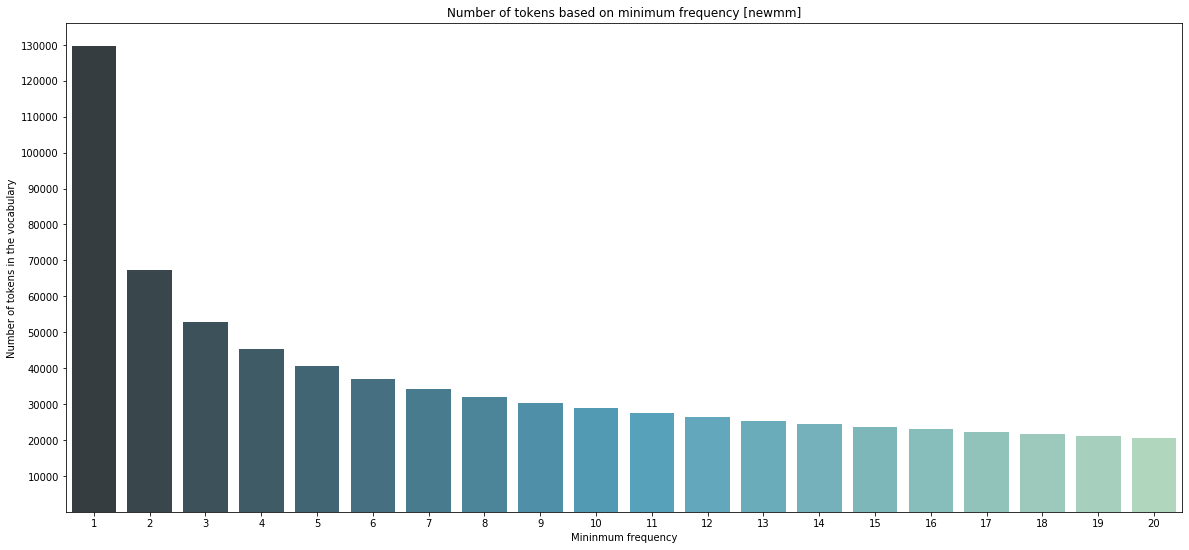

In [142]:
plt.figure(figsize=(20,9))
N = 20
ax = sns.barplot(x=[i for i in range(1,N+1,1)], y=freq_k_list[:N], palette="GnBu_d")
ax.set_title('Number of tokens based on minimum frequency [newmm]')
ax.set_yticks([v for v in range(10000,140000,10000)])
ax.set_xlabel('Mininmum frequency')
ax.set_ylabel('Number of tokens in the vocabulary')

#### English word frequency 

In [143]:

tokenizer_names = ['newmm']
tokenizer_names.extend(['sentencepiece-{}'.format(vocab_size) for vocab_size in bpemb_vocab_sizes])
tokenizer_names

['newmm',
 'sentencepiece-1000',
 'sentencepiece-3000',
 'sentencepiece-5000',
 'sentencepiece-10000',
 'sentencepiece-25000',
 'sentencepiece-50000',
 'sentencepiece-100000',
 'sentencepiece-200000']

In [144]:
english_counters = count_word_freq(opensubtitle_en[:], tokenizer_names)


Counter [newmm] :[('.', 2493522), (',', 1273070), ("'", 1267573), ('I', 853125), ('you', 705677), ('?', 669033), ('the', 573550), ('to', 519353), ('s', 461481), ('a', 399558), ('t', 302187), ('-', 301527), ('it', 289676), ('!', 264764), ('that', 252674), ('of', 243462), ('You', 228716), ('and', 206070), ('me', 203448), ('is', 199529), ('...', 195823), ('in', 192377), ('m', 154094), ('this', 147270), ('re', 145230), ('on', 143357), ('for', 142762), ('have', 137436), ('your', 132693), ('know', 131411), ('was', 130604), ('we', 130059), ('my', 128105), ('be', 125810), ('It', 121690), ('What', 120705), ('not', 116126), ('do', 113608), ('can', 109764), ('are', 108884), ('with', 105764), ('what', 103600), ('don', 102111), ('he', 98119), ('just', 94175), ('We', 88185), ('here', 86893), ('And', 85129), ('No', 82478), ('out', 82460), ('like', 81109), ('all', 79842), ('about', 78259), ('right', 77207), ('get', 76941), ('ll', 76303), ('him', 74561), ('up', 73521), ('The', 70510), ('her', 69080), 


Counter [sentencepiece-1000] :[('▁', 9185763), ('e', 5242671), ('o', 5080875), ('h', 3616931), ('t', 3251675), ('u', 3175849), ('.', 3150975), ('i', 2858181), ('y', 2855100), ('▁t', 2769796), ('l', 2518500), ('s', 2430936), ('a', 2378428), ('d', 2115573), ('g', 2065123), ('▁w', 1603529), ('in', 1401943), ('n', 1396336), ('▁s', 1318448), ('m', 1300958), ('he', 1297960), (',', 1289425), ("'", 1272052), ('k', 1207459), ('r', 1198531), ('er', 1167374), ('an', 1131796), ('▁m', 994986), ('on', 945211), ('at', 944055), ('▁b', 870930), ('▁a', 855170), ('c', 831646), ('▁d', 830373), ('v', 811423), ('▁c', 790649), ('it', 782175), ('p', 747256), ('f', 732825), ('▁o', 683166), ('?', 678054), ('is', 666168), ('w', 653888), ('▁f', 635285), ('or', 606609), ('en', 606450), ('ar', 577899), ('re', 553558), ('al', 513893), ('▁p', 479550), ('es', 465126), ('le', 416581), ('b', 399575), ('▁-', 329632), ('!', 267487), ('ro', 260490), ('j', 233998), ('ic', 200492), ('-', 155678), ('x', 104040), ('z', 59876)


Counter [sentencepiece-3000] :[('e', 2877956), ('.', 2523492), ('o', 1560815), ('▁w', 1421393), (',', 1283864), ("'", 1272052), ('▁y', 1262031), ('▁', 1216329), ('s', 1169246), ('y', 1026895), ('ou', 1002629), ('▁m', 994986), ('er', 981512), ('h', 934633), ('▁h', 898560), ('▁th', 889129), ('▁i', 866248), ('▁s', 862104), ('at', 848301), ('▁the', 813923), ('t', 805303), ('▁a', 771401), ('▁d', 762592), ('▁g', 695849), ('ing', 687217), ('?', 678054), ('it', 625446), ('▁to', 614319), ('▁b', 567123), ('n', 555837), ('l', 527524), ('▁c', 521544), ('d', 520344), ('a', 511864), ('k', 491942), ('▁n', 480858), ('on', 476522), ('▁l', 472213), ('m', 458633), ('▁f', 456674), ('▁t', 432770), ('an', 425355), ('en', 402165), ('ed', 399454), ('▁p', 396066), ('▁o', 392043), ('ow', 385206), ('ut', 376222), ('p', 368339), ('is', 357273), ('v', 339927), ('re', 337857), ('▁-', 329632), ('in', 322742), ('▁he', 317537), ('ay', 311726), ('r', 309561), ('or', 306305), ('c', 301479), ('le', 298883), ('f', 295286


Counter [sentencepiece-5000] :[('.', 2518501), ('e', 1301207), (',', 1278482), ("'", 1255514), ('s', 1078390), ('▁you', 936630), ('▁h', 898560), ('▁th', 889129), ('o', 873787), ('▁i', 866098), ('▁the', 813923), ('▁d', 762592), ('y', 732459), ('▁w', 730299), ('at', 708582), ('ing', 678965), ('?', 678054), ('▁a', 676928), ('▁s', 655509), ('t', 637430), ('▁to', 614319), ('▁g', 601152), ('▁m', 483277), ('▁b', 463382), ('▁l', 442112), ('n', 430767), ('er', 424024), ('▁wh', 421503), ('▁it', 418886), ('k', 400656), ('▁c', 392712), ('▁o', 392043), ('ow', 385206), ('ed', 382147), ('ut', 376222), ('▁', 369675), ('d', 368634), ('m', 362892), ('en', 357155), ('▁f', 357108), ('on', 343183), ('▁t', 337861), ('an', 336259), ('▁-', 329632), ('▁y', 325401), ('▁p', 322023), ('▁n', 319118), ('is', 317670), ('▁he', 317537), ('ay', 311726), ('▁and', 293987), ('▁in', 293419), ('ot', 293103), ('▁of', 291123), ('ere', 289821), ('▁k', 289417), ('a', 285961), ('le', 281721), ('es', 277074), ('h', 276399), ('▁b


Counter [sentencepiece-10000] :[('.', 2499922), (',', 1277696), ("'", 1255514), ('▁you', 936630), ('s', 898791), ('▁i', 866098), ('▁the', 797193), ('▁h', 735141), ('?', 678054), ('ing', 643333), ('▁to', 610296), ('▁a', 585642), ('▁s', 564280), ('y', 532207), ('▁w', 513826), ('t', 496941), ('▁wh', 421503), ('▁it', 418886), ('▁th', 379018), ('ed', 368679), ('▁g', 365186), ('▁m', 344393), ('e', 333230), ('▁-', 329632), ('▁that', 321207), ('ow', 314367), ('▁d', 311452), ('▁l', 308188), ('▁he', 307621), ('at', 306962), ('▁f', 296050), ('en', 294397), ('▁and', 293987), ('m', 292658), ('ere', 289821), ('▁t', 286376), ('▁in', 274271), ('▁be', 269907), ('!', 267487), ('▁me', 263203), ('▁of', 256850), ('▁o', 256117), ('▁we', 239771), ('▁is', 239393), ('o', 233888), ('d', 230196), ('▁', 217536), ('▁do', 209286), ('es', 208269), ('▁b', 208039), ('et', 207806), ('...', 195204), ('re', 194803), ('▁p', 194696), ('▁c', 193500), ('▁this', 188810), ('▁j', 186521), ('ay', 186109), ('▁on', 185951), ('▁r'


Counter [sentencepiece-25000] :[('.', 2499629), (',', 1275160), ("'", 1255514), ('▁you', 936630), ('▁i', 866021), ('s', 694952), ('?', 672869), ('▁the', 668160), ('▁to', 603433), ('ing', 477033), ('▁a', 463682), ('▁it', 412980), ('t', 385573), ('▁-', 324693), ('▁that', 321207), ('▁and', 293043), ('ed', 268956), ('▁me', 261995), ('!', 259504), ('▁of', 256850), ('▁is', 237612), ('▁in', 234269), ('▁we', 230198), ('▁what', 224790), ('m', 213747), ('▁h', 213307), ('▁do', 209286), ('▁th', 200294), ('▁d', 197592), ('▁he', 196523), ('▁be', 194405), ('...', 194294), ('y', 192281), ('▁this', 188810), ('▁for', 172106), ('re', 167942), ('es', 163470), ('▁your', 163433), ('▁s', 161939), ('▁no', 161740), ('▁my', 160659), ('id', 159818), ('▁g', 157979), ('▁on', 152308), ('▁w', 150742), ('▁was', 146644), ('▁have', 144923), ('n', 140605), ('▁not', 137977), ('▁go', 135707), ('▁know', 134776), ('▁an', 132837), ('▁don', 130113), ('▁are', 128970), ('▁p', 128705), ('▁t', 128627), ('▁can', 127060), ('▁so', 


Counter [sentencepiece-50000] :[('.', 2499466), (',', 1274247), ("'", 1254645), ('▁you', 936360), ('▁i', 865835), ('?', 672826), ('▁the', 647424), ('s', 638186), ('▁to', 549506), ('▁a', 452913), ('▁it', 412969), ('t', 333938), ('▁-', 324647), ('▁that', 321207), ('ing', 311120), ('▁and', 291798), ('!', 259504), ('▁of', 256850), ('▁is', 235744), ('▁we', 230198), ('▁what', 224790), ('▁in', 223867), ('ed', 223212), ('▁me', 221129), ('...', 194221), ('▁he', 193887), ('▁this', 188810), ('m', 175170), ('▁do', 168018), ('▁for', 166435), ('▁your', 163433), ('re', 160280), ('▁my', 159317), ('▁on', 152308), ('▁was', 146644), ('▁have', 144923), ('▁no', 143800), ('▁be', 141702), ('▁not', 136395), ('▁know', 134155), ('▁don', 129930), ('▁are', 128970), ('▁can', 126046), ('▁so', 121002), ('n', 120530), ('▁just', 117630), ('▁with', 111578), ('▁but', 110303), ('▁all', 110005), ('▁g', 99765), ('▁some', 97085), ('▁here', 96870), ('▁there', 95620), ('-', 93659), ('▁get', 92998), ('▁she', 92406), ('▁did', 


Counter [sentencepiece-100000] :[('.', 2498020), (',', 1273895), ("'", 1253181), ('▁you', 936360), ('▁i', 865528), ('?', 672826), ('▁the', 647037), ('s', 592062), ('▁to', 538030), ('▁a', 439832), ('▁it', 412710), ('▁-', 324621), ('▁that', 321207), ('t', 316139), ('▁and', 291755), ('!', 259384), ('▁of', 255754), ('▁is', 235112), ('▁what', 224790), ('▁we', 223481), ('▁in', 214530), ('▁me', 214103), ('ing', 212678), ('...', 194106), ('▁this', 188810), ('▁he', 180622), ('▁do', 166984), ('m', 165397), ('▁for', 159807), ('▁your', 154205), ('▁my', 151983), ('re', 149347), ('▁on', 148915), ('▁was', 146644), ('▁have', 144923), ('ed', 144183), ('▁no', 142999), ('▁be', 138472), ('▁not', 136376), ('▁know', 134155), ('▁don', 129930), ('▁are', 128745), ('▁can', 125694), ('▁just', 117323), ('▁so', 113135), ('n', 111663), ('▁with', 111578), ('▁but', 109536), ('▁all', 107479), ('▁here', 96870), ('▁there', 95600), ('-', 93608), ('▁get', 92998), ('▁did', 92321), ('▁she', 91684), ('▁like', 88345), ('▁the


Counter [sentencepiece-200000] :[('.', 2496722), (',', 1273707), ("'", 1252044), ('▁you', 936360), ('▁i', 865296), ('?', 672824), ('▁the', 645343), ('▁to', 534310), ('s', 528493), ('▁a', 432172), ('▁it', 412489), ('▁-', 324556), ('▁that', 321207), ('t', 308341), ('▁and', 291741), ('!', 259382), ('▁of', 252839), ('▁what', 224790), ('▁is', 221745), ('▁we', 219309), ('▁me', 212084), ('▁in', 209831), ('...', 194098), ('▁this', 188810), ('▁he', 169812), ('m', 160381), ('▁for', 157096), ('▁my', 151922), ('▁your', 149836), ('▁on', 148823), ('re', 148416), ('▁have', 144923), ('▁no', 141938), ('▁do', 138858), ('▁not', 134901), ('▁was', 134701), ('▁be', 134245), ('▁know', 134155), ('▁don', 129572), ('▁are', 128745), ('▁can', 124864), ('▁just', 117211), ('ing', 114540), ('▁so', 112388), ('▁with', 111303), ('▁but', 108321), ('▁all', 106702), ('ed', 104753), ('▁here', 96870), ('▁there', 95242), ('-', 93412), ('▁get', 92998), ('▁she', 90805), ('▁like', 88345), ('▁they', 87862), ('▁out', 87435), ('▁

In [145]:
# Number of vocabulary for newmm

# all frequency
print('number of vocabulary (newmm):')
freq_k_list = []
for k in range(1,51, 1):
    freq_k = sum(1 for i in english_counters['newmm'].values() if i >= k)
    print('min_freq = {} : {}'.format(k, freq_k))
    freq_k_list.append(freq_k)

number of vocabulary (newmm):
min_freq = 1 : 192274
min_freq = 2 : 105155
min_freq = 3 : 81261
min_freq = 4 : 68809
min_freq = 5 : 60389
min_freq = 6 : 54319
min_freq = 7 : 49610
min_freq = 8 : 45993
min_freq = 9 : 42936
min_freq = 10 : 40315
min_freq = 11 : 38064
min_freq = 12 : 36098
min_freq = 13 : 34360
min_freq = 14 : 32806
min_freq = 15 : 31441
min_freq = 16 : 30237
min_freq = 17 : 29079
min_freq = 18 : 28033
min_freq = 19 : 27134
min_freq = 20 : 26307
min_freq = 21 : 25507
min_freq = 22 : 24760
min_freq = 23 : 24050
min_freq = 24 : 23389
min_freq = 25 : 22774
min_freq = 26 : 22214
min_freq = 27 : 21708
min_freq = 28 : 21196
min_freq = 29 : 20736
min_freq = 30 : 20282
min_freq = 31 : 19849
min_freq = 32 : 19430
min_freq = 33 : 19015
min_freq = 34 : 18630
min_freq = 35 : 18300
min_freq = 36 : 17964
min_freq = 37 : 17638
min_freq = 38 : 17372
min_freq = 39 : 17082
min_freq = 40 : 16798
min_freq = 41 : 16511
min_freq = 42 : 16260
min_freq = 43 : 16022
min_freq = 44 : 15779
min_freq 

In [146]:
# test BPE
bpemb_th['{}'.format(100000)].encode("I live in New York city")

['▁i', '▁live', '▁in', '▁new', '▁york', '▁city']